In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment/anomaly_detection_test_data/good/23_09_2024_11_17_24.022848_cls_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/17_08_2024_18_41_12.334727_classifier_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/25_08_2024_15_21_02.339018_cls_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/27_08_2024_18_14_53.148653_cls_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/17_08_2024_18_57_30.215962_classifier_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/05_08_2024_11_49_15.023396_classifier_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/13_08_2024_18_55_32.151968_classifier_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/05_08_2024_11_51_34.323854_classifier_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/24_08_2024_17_02_58.234886_cls_input.png
/kaggle/input/assignment/anomaly_detection_test_data/good/23_09_2024_11_18

In [34]:
import os
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


DATA_DIR = "/kaggle/input/assignment/anomaly_detection_test_data" 
PRETRAINED_WEIGHTS = "resnet18-f37072fd.pth" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

class CustomDataset(Dataset):
    def __init__(self, good_dir, bad_dir, transform=None):
        self.good_images = [os.path.join(good_dir, fname) for fname in os.listdir(good_dir)]
        self.bad_images = [os.path.join(bad_dir, fname) for fname in os.listdir(bad_dir)]
        self.all_images = self.good_images + self.bad_images
        
        
        self.labels = [0] * len(self.good_images) + [1] * len(self.bad_images)
        
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(
    good_dir=os.path.join(DATA_DIR, "good"),
    bad_dir=os.path.join(DATA_DIR, "bad"),
    transform=transform
)

train_size = int(TRAIN_SPLIT * len(dataset))
val_size = int(VAL_SPLIT * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = models.resnet18(weights=None)
if os.path.exists(PRETRAINED_WEIGHTS):
    print("Loading pretrained weights from local file...")
    model.load_state_dict(torch.load(PRETRAINED_WEIGHTS))

model.fc = nn.Linear(model.fc.in_features, 2) 
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy, all_labels, all_preds

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

torch.save(model.state_dict(), "scratch_detector_4.pth")
print("Model training complete. Weights saved to 'scratch_detector.pth'")

test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=["Good", "Bad"])

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Epoch 1/15: Train Loss: 0.4046, Val Loss: 2.1775, Val Accuracy: 0.4064
Epoch 2/15: Train Loss: 0.2909, Val Loss: 6.2371, Val Accuracy: 0.2925
Epoch 3/15: Train Loss: 0.2124, Val Loss: 3.8296, Val Accuracy: 0.2442
Epoch 4/15: Train Loss: 0.1638, Val Loss: 0.3307, Val Accuracy: 0.8494
Epoch 5/15: Train Loss: 0.1111, Val Loss: 0.1136, Val Accuracy: 0.9595
Epoch 6/15: Train Loss: 0.1021, Val Loss: 0.1919, Val Accuracy: 0.9151
Epoch 7/15: Train Loss: 0.1010, Val Loss: 0.1042, Val Accuracy: 0.9595
Epoch 8/15: Train Loss: 0.0679, Val Loss: 0.0937, Val Accuracy: 0.9595
Epoch 9/15: Train Loss: 0.0648, Val Loss: 0.2273, Val Accuracy: 0.9218
Epoch 10/15: Train Loss: 0.0732, Val Loss: 0.0900, Val Accuracy: 0.9759
Epoch 11/15: Train Loss: 0.0718, Val Loss: 0.0709, Val Accuracy: 0.9778
Epoch 12/15: Train Loss: 0.0325, Val Loss: 0.0578, Val Accuracy: 0.9836
Epoch 13/15: Train Loss: 0.0245, Val Loss: 0.2164, Val Accuracy: 0.9469
Epoch 14/15: Train Loss: 0.0375, Val Loss: 0.0476, Val Accuracy: 0.9855
E

In [26]:
def predict(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    if predicted == 0:
        return "Good"
    else:
        return "Bad"


image_path = "/kaggle/input/assignment/anomaly_detection_test_data/bad/09_08_2024_18_27_40.091852_classifier_input.png"  
result = predict(model, image_path)
print(f"The image is: {result}")

The image is: Good


# Segmentation

In [36]:
import os
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np


DATA_DIR = "/kaggle/input/assignment/anomaly_detection_test_data"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
EPOCHS = 15
LEARNING_RATE = 0.001

class MaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


dataset = MaskDataset(
    image_dir=os.path.join(DATA_DIR, "bad"), 
    mask_dir=os.path.join(DATA_DIR, "masks"),  
    transform=image_transform,
    mask_transform=mask_transform
)


train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = models.resnet34(pretrained=False) 
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.encoder = nn.Sequential(*self.encoder_layers)

    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 


model = UNet().to(DEVICE)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


def iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_score(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2.0 * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)


for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    iou_train, dice_train = 0, 0


    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        
        iou_train += iou(outputs, masks).item()
        dice_train += dice_score(outputs, masks).item()

    
    iou_train /= len(train_loader)
    dice_train /= len(train_loader)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.4f}, IoU: {iou_train:.4f}, Dice: {dice_train:.4f}")

    
    model.eval()
    iou_val, dice_val = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)

            iou_val += iou(outputs, masks).item()
            dice_val += dice_score(outputs, masks).item()

    
    iou_val /= len(val_loader)
    dice_val /= len(val_loader)
    print(f"Validation IoU: {iou_val:.4f}, Validation Dice: {dice_val:.4f}")


torch.save(model.state_dict(), "segmentation_model_5.pth")
print("Model saved as 'segmentation_model.pth'")


def evaluate(model, dataloader):
    model.eval()
    iou_total, dice_total = 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)

            iou_total += iou(outputs, masks).item()
            dice_total += dice_score(outputs, masks).item()

    iou_avg = iou_total / len(dataloader)
    dice_avg = dice_total / len(dataloader)
    return iou_avg, dice_avg

test_iou, test_dice = evaluate(model, test_loader)
print(f"Test IoU: {test_iou:.4f}, Test Dice Score: {test_dice:.4f}")


Epoch 1/15, Loss: 0.1691, IoU: 0.0009, Dice: 0.0017
Validation IoU: 0.0000, Validation Dice: 0.0001
Epoch 2/15, Loss: 0.1205, IoU: 0.0000, Dice: 0.0001
Validation IoU: 0.0004, Validation Dice: 0.0009
Epoch 3/15, Loss: 0.0971, IoU: 0.2045, Dice: 0.3077
Validation IoU: 0.0859, Validation Dice: 0.1367
Epoch 4/15, Loss: 0.0937, IoU: 0.3105, Dice: 0.4568
Validation IoU: 0.3420, Validation Dice: 0.4787
Epoch 5/15, Loss: 0.0817, IoU: 0.3579, Dice: 0.5057
Validation IoU: 0.4227, Validation Dice: 0.5847
Epoch 6/15, Loss: 0.0835, IoU: 0.3626, Dice: 0.5047
Validation IoU: 0.1900, Validation Dice: 0.2900
Epoch 7/15, Loss: 0.0769, IoU: 0.4026, Dice: 0.5571
Validation IoU: 0.2509, Validation Dice: 0.3948
Epoch 8/15, Loss: 0.0718, IoU: 0.4500, Dice: 0.6081
Validation IoU: 0.4276, Validation Dice: 0.5835
Epoch 9/15, Loss: 0.0701, IoU: 0.4591, Dice: 0.6127
Validation IoU: 0.2569, Validation Dice: 0.3808
Epoch 10/15, Loss: 0.0698, IoU: 0.4481, Dice: 0.6022
Validation IoU: 0.1381, Validation Dice: 0.2157

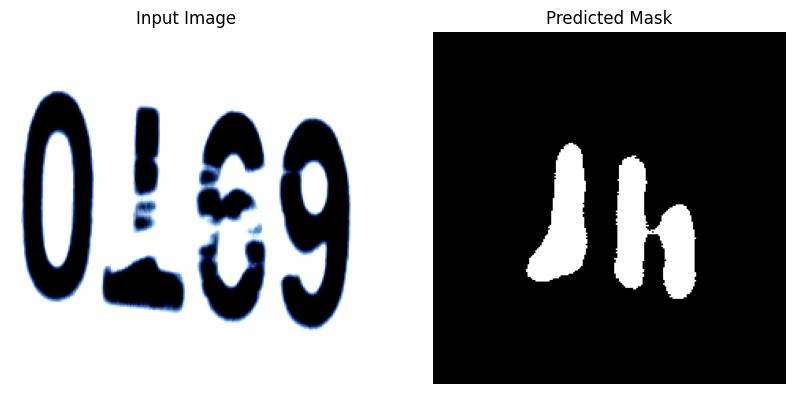

In [16]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict(model, image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0) 
    image = image.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image)
        output = output.squeeze(0) 
        output = output.cpu().numpy() 
        output = (output > 0.5).astype(np.uint8) 

    
    output_image = Image.fromarray(output[0] * 255)  
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0)) 
    plt.title("Input Image")
    plt.axis("off")

    
    plt.subplot(1, 2, 2)
    plt.imshow(output_image, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


input_image_path = "/kaggle/input/assignment/anomaly_detection_test_data/bad/03_08_2024_16_55_10.563042_classifier_input.png" 
predict(model, input_image_path, image_transform, DEVICE)


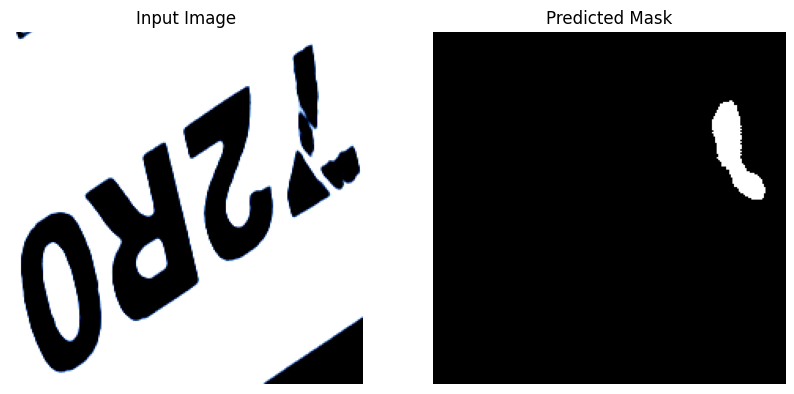

In [18]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


def predict(model, image_path, transform, device):
   
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0) 

    image = image.to(device)
    model.eval()

    with torch.no_grad():
       
        output = model(image)

       
        output = output.squeeze(0)  
        output = output.cpu().numpy()  
        output = (output > 0.5).astype(np.uint8)  

    output_image = Image.fromarray(output[0] * 255) 
    
  
    plt.figure(figsize=(10, 5))


    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0)) 
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()
    
input_image_path = "/kaggle/input/assignment/anomaly_detection_test_data/bad/09_08_2024_18_32_02.122764_classifier_input.png"  
predict(model, input_image_path, image_transform, DEVICE)
